In [1]:
library(tidyverse)
library(mice)
library(VIM)
library(naniar)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be 

In [2]:
GIT_ROOT <- system2("git", args = c("rev-parse", "--show-toplevel"), stdout=TRUE)
INGEST <- file.path(GIT_ROOT, "build/ingest")
UTIL <- file.path(GIT_ROOT, "src/util.R") 

In [3]:
# Construct and return a dataframe from the given dataset where 
# the heart disease class is grouped by the target attribute with
# classes given as a vector. The columns in the dataframe will be
# 'heart_disease_class', the name of the grouping attribute, and 
# 'fraction', which is the fraction of the attribute that belongs
# to the heart disease class given by the first column.
group_by_attribute <- function(dataset, attribute, classes) {
    class_totals <- list()
    for(i in 1:length(classes)) class_totals[i] <- sum(dataset[[attribute]] == classes[i], na.rm=TRUE)
    fractions <- list()
    categories <- list()
    categories_by_attribute <- data.frame()
    for(heart_disease_class in 0:4) {
        for(i in 1:length(classes)) {
            attribute_class <- classes[i]
            samples_per_class <- dataset[dataset$target == heart_disease_class,][[attribute]] == attribute_class
            sample_count <- sum(samples_per_class, na.rm=TRUE)
            class_total <- class_totals[[i]]
            fraction <- sample_count / class_total
            categories_by_attribute <- rbind(categories_by_attribute, 
                                             c(heart_disease_class, attribute_class, fraction))       
        }
    }
    colnames(categories_by_attribute) <- c('heart_disease_class', attribute, 'fraction')
    return(categories_by_attribute)
}

In [4]:
source(UTIL)
uci_dataset <- read_dir(INGEST, 
                        features = c('age', 'sex', 'cp', 'trestbps', 'fbs', 'restecg', 
                                     'thalach', 'exang', 'oldpeak', 'chol', 'target'))
summary(uci_dataset$df)

iteration 1:
    age sex cp trestbps fbs restecg thalach exang oldpeak chol target
1    63   1  1      145   1       2     150     0     2.3  233      0
2    67   1  4      160   0       2     108     1     1.5  286      2
3    67   1  4      120   0       2     129     1     2.6  229      1
4    37   1  3      130   0       0     187     0     3.5  250      0
5    41   0  2      130   0       2     172     0     1.4  204      0
6    56   1  2      120   0       0     178     0     0.8  236      0
7    62   0  4      140   0       2     160     0     3.6  268      3
8    57   0  4      120   0       0     163     1     0.6  354      0
9    63   1  4      130   0       2     147     0     1.4  254      2
10   53   1  4      140   1       2     155     1     3.1  203      1
11   57   1  4      140   0       0     148     0     0.4  192      0
12   56   0  2      140   0       2     153     0     1.3  294      0
13   56   1  3      130   1       2     142     1     0.6  256      2
14   44

      age             sex               cp          trestbps    
 Min.   :28.00   Min.   :0.0000   Min.   :1.00   Min.   :  0.0  
 1st Qu.:47.00   1st Qu.:1.0000   1st Qu.:3.00   1st Qu.:120.0  
 Median :54.00   Median :1.0000   Median :4.00   Median :130.0  
 Mean   :53.51   Mean   :0.7891   Mean   :3.25   Mean   :132.1  
 3rd Qu.:60.00   3rd Qu.:1.0000   3rd Qu.:4.00   3rd Qu.:140.0  
 Max.   :77.00   Max.   :1.0000   Max.   :4.00   Max.   :200.0  
                                                 NA's   :59     
      fbs            restecg          thalach          exang       
 Min.   :0.0000   Min.   :0.0000   Min.   : 60.0   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:120.0   1st Qu.:0.0000  
 Median :0.0000   Median :0.0000   Median :140.0   Median :0.0000  
 Mean   :0.1663   Mean   :0.6046   Mean   :137.5   Mean   :0.3896  
 3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:157.0   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :2.0000   Max.   :202.0   Max.   :1.0000  
 NA'

In [5]:
uci_dataset$df <- replace_with_na(uci_dataset$df, replace = list(chol = 0, trestbps = 0))
uci_dataset$df

age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,chol,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
63,1,1,145,1,2,150,0,2.3,233,0
67,1,4,160,0,2,108,1,1.5,286,2
67,1,4,120,0,2,129,1,2.6,229,1
37,1,3,130,0,0,187,0,3.5,250,0
41,0,2,130,0,2,172,0,1.4,204,0
56,1,2,120,0,0,178,0,0.8,236,0
62,0,4,140,0,2,160,0,3.6,268,3
57,0,4,120,0,0,163,1,0.6,354,0
63,1,4,130,0,2,147,0,1.4,254,2


,age,sex,cp,target,restecg,thalach,exang,trestbps,oldpeak,fbs,chol,
661,1,1,1,1,1,1,1,1,1,1,1,0
105,1,1,1,1,1,1,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,0,1,1
75,1,1,1,1,1,1,1,1,1,0,0,2
3,1,1,1,1,1,1,1,1,0,1,1,1
1,1,1,1,1,1,1,1,1,0,1,0,2
3,1,1,1,1,1,1,1,1,0,0,0,3
1,1,1,1,1,1,1,1,0,1,1,1,1
3,1,1,1,1,1,1,1,0,1,1,0,2
1,1,1,1,1,1,1,1,0,0,0,0,4


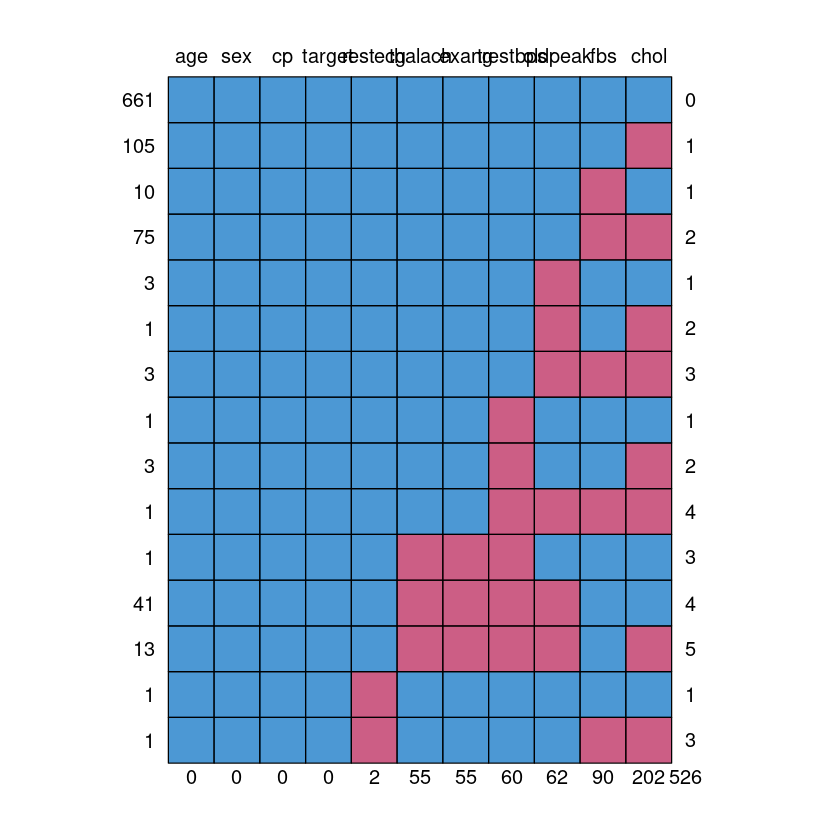

In [6]:
md.pattern(uci_dataset$df)

In [7]:
md.pairs(uci_dataset$df)

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,chol,target
age,920,920,920,860,830,918,865,865,858,718,920
sex,920,920,920,860,830,918,865,865,858,718,920
cp,920,920,920,860,830,918,865,865,858,718,920
trestbps,860,860,860,860,771,858,860,860,853,675,860
fbs,830,830,830,771,830,829,775,775,772,708,830
restecg,918,918,918,858,829,918,863,863,856,717,918
thalach,865,865,865,860,775,863,865,865,857,676,865
exang,865,865,865,860,775,863,865,865,857,676,865
oldpeak,858,858,858,853,772,856,857,857,858,674,858
chol,718,718,718,675,708,717,676,676,674,718,718


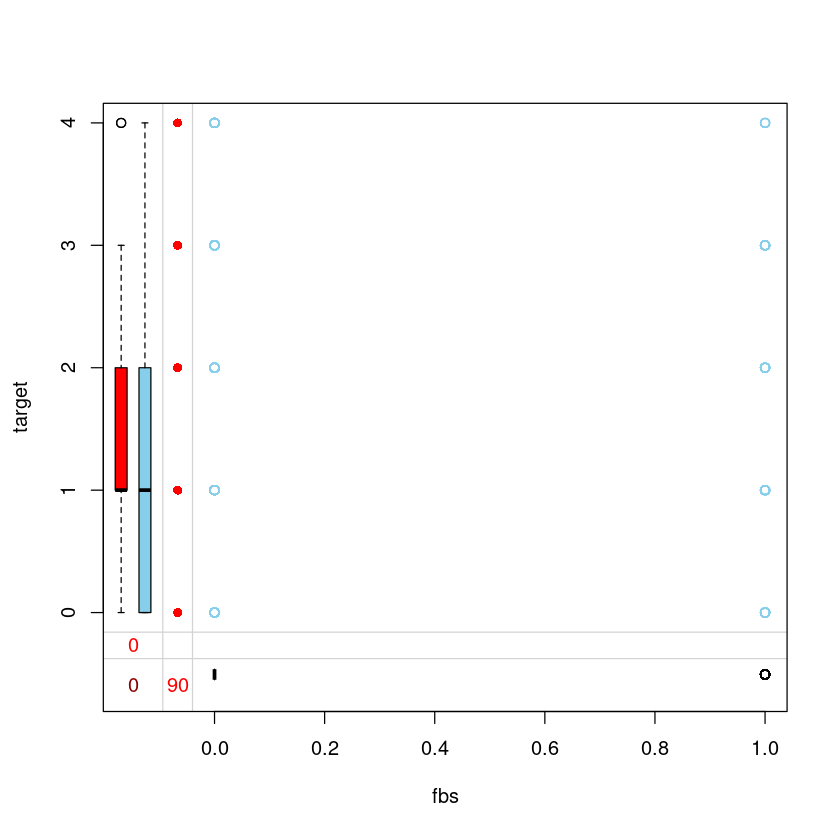

In [8]:
marginplot(uci_dataset$df[, c("fbs", "target")])

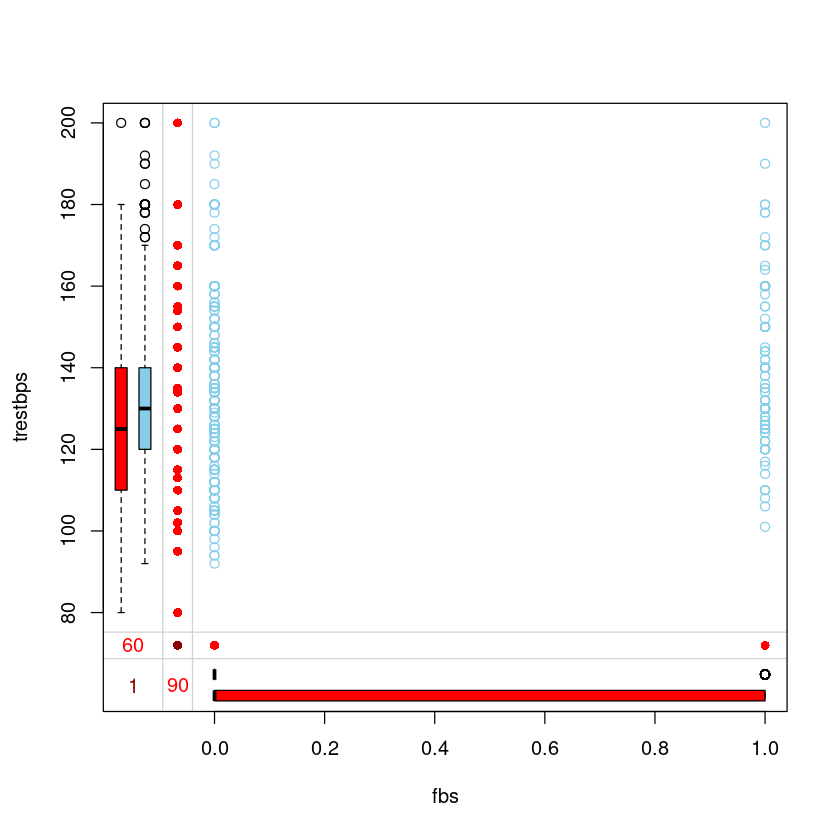

In [9]:
marginplot(uci_dataset$df[, c("fbs", "trestbps")])

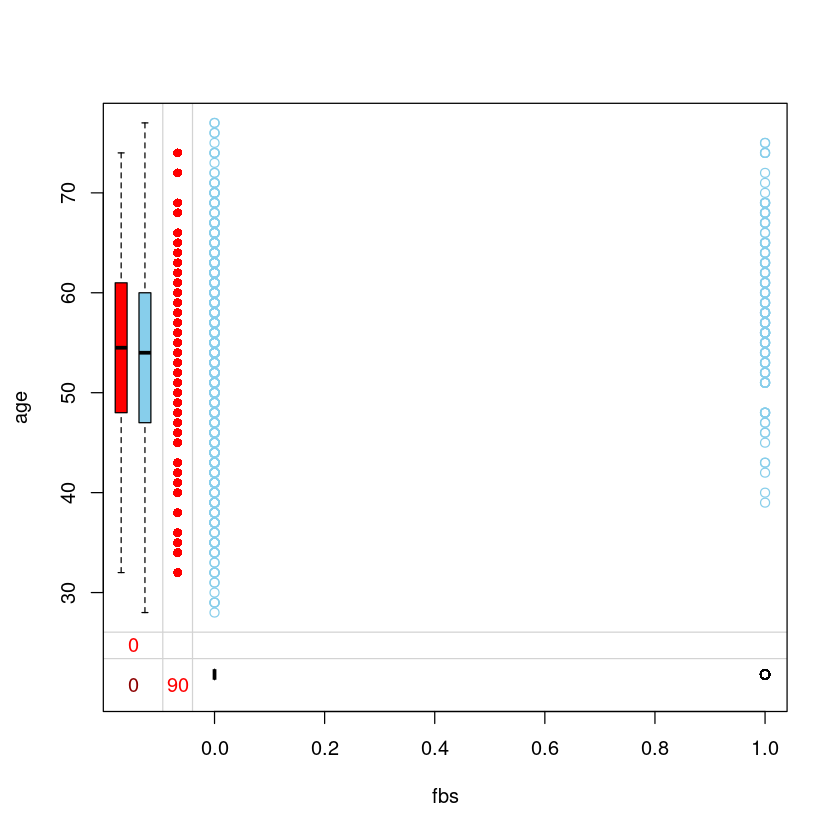

In [10]:
marginplot(uci_dataset$df[, c("fbs", "age")])

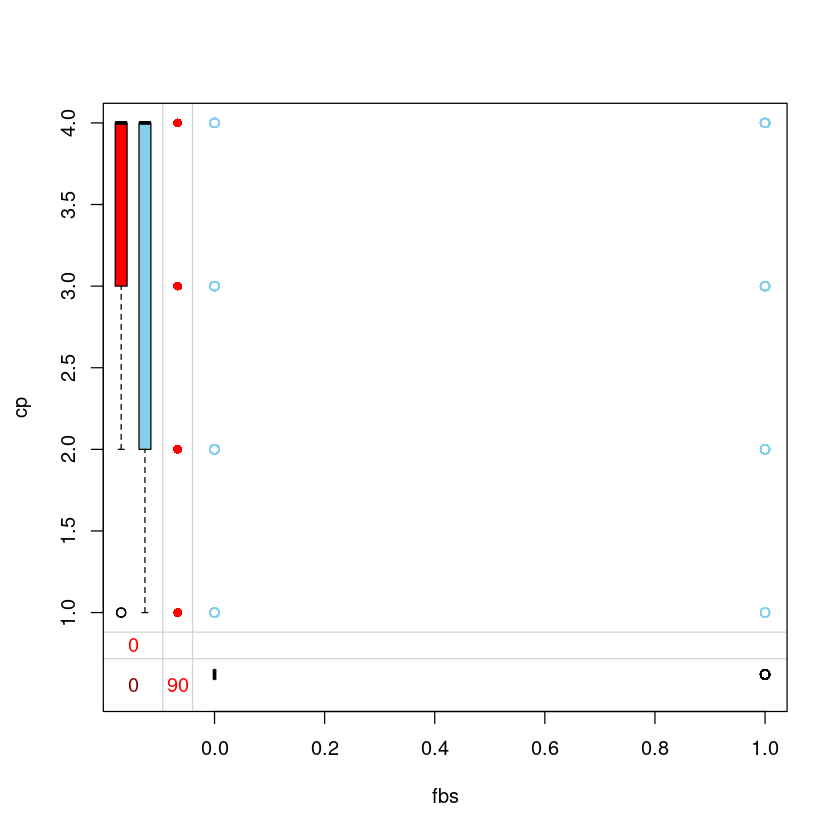

In [11]:
marginplot(uci_dataset$df[, c("fbs", "cp")])

,age,sex,cp,thalach,exang,target,trestbps,restecg,oldpeak,fbs,chol,
661,1,1,1,1,1,1,1,1,1,1,1,0
105,1,1,1,1,1,1,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,0,1,1
3,1,1,1,1,1,1,1,1,0,1,1,1
1,1,1,1,1,1,1,1,0,1,1,1,1
1,1,1,1,1,1,1,0,1,1,1,1,1
,0,0,0,0,0,0,1,1,3,10,105,120


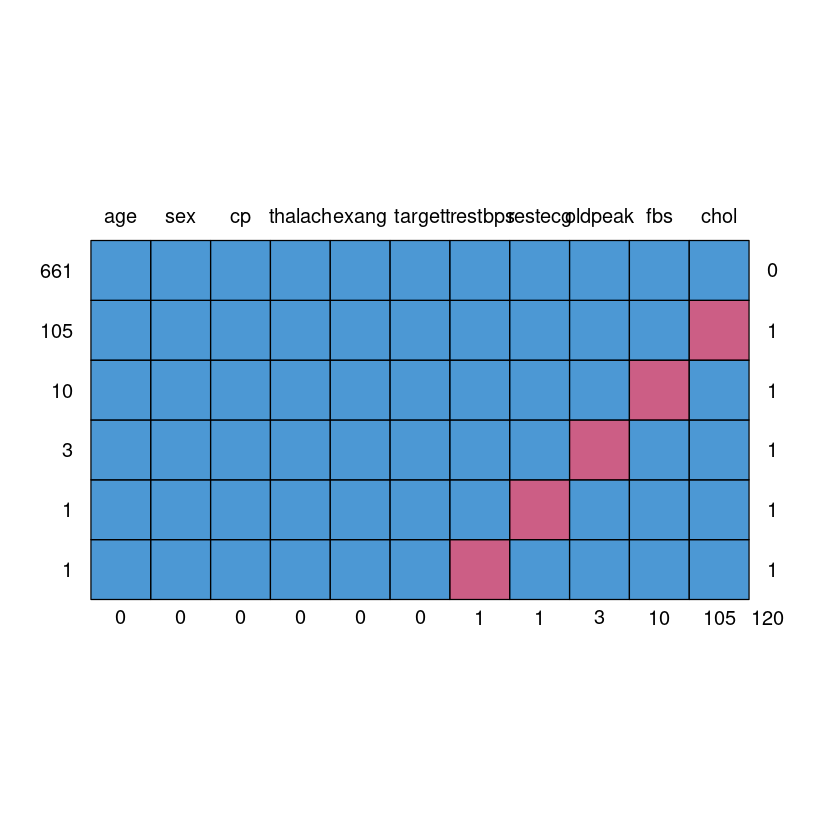

In [12]:
uci_dataset$df <- uci_dataset$df[rowSums(is.na(uci_dataset$df))<2,]
md.pattern(uci_dataset$df)

In [13]:
uci_dataset$df$restecg <- as.factor(uci_dataset$df$restecg)
uci_dataset$df$fbs <- as.factor(uci_dataset$df$fbs)

In [14]:
imp <- mice(uci_dataset$df, 
            seed = 1467756838, 
            method = c("", "", "", "", "logreg", "polyreg", "", "", "pmm", "pmm", ""),
            visit = "monotone",
            maxit = 60,
            m = 5)


 iter imp variable
  1   1  restecg  oldpeak  fbs  chol
  1   2  restecg  oldpeak  fbs  chol
  1   3  restecg  oldpeak  fbs  chol
  1   4  restecg  oldpeak  fbs  chol
  1   5  restecg  oldpeak  fbs  chol
  2   1  restecg  oldpeak  fbs  chol
  2   2  restecg  oldpeak  fbs  chol
  2   3  restecg  oldpeak  fbs  chol
  2   4  restecg  oldpeak  fbs  chol
  2   5  restecg  oldpeak  fbs  chol
  3   1  restecg  oldpeak  fbs  chol
  3   2  restecg  oldpeak  fbs  chol
  3   3  restecg  oldpeak  fbs  chol
  3   4  restecg  oldpeak  fbs  chol
  3   5  restecg  oldpeak  fbs  chol
  4   1  restecg  oldpeak  fbs  chol
  4   2  restecg  oldpeak  fbs  chol
  4   3  restecg  oldpeak  fbs  chol
  4   4  restecg  oldpeak  fbs  chol
  4   5  restecg  oldpeak  fbs  chol
  5   1  restecg  oldpeak  fbs  chol
  5   2  restecg  oldpeak  fbs  chol
  5   3  restecg  oldpeak  fbs  chol
  5   4  restecg  oldpeak  fbs  chol
  5   5  restecg  oldpeak  fbs  chol
  6   1  restecg  oldpeak  fbs  chol
  6   2  restecg  

In [15]:
imputed_dataset <- complete(imp, 1)
imp

Class: mids
Number of multiple imputations:  5 
Imputation methods:
      age       sex        cp  trestbps       fbs   restecg   thalach     exang 
       ""        ""        ""        ""  "logreg" "polyreg"        ""        "" 
  oldpeak      chol    target 
    "pmm"     "pmm"        "" 
PredictorMatrix:
         age sex cp trestbps fbs restecg thalach exang oldpeak chol target
age        0   1  1        1   1       1       1     1       1    1      1
sex        1   0  1        1   1       1       1     1       1    1      1
cp         1   1  0        1   1       1       1     1       1    1      1
trestbps   1   1  1        0   1       1       1     1       1    1      1
fbs        1   1  1        1   0       1       1     1       1    1      1
restecg    1   1  1        1   1       0       1     1       1    1      1

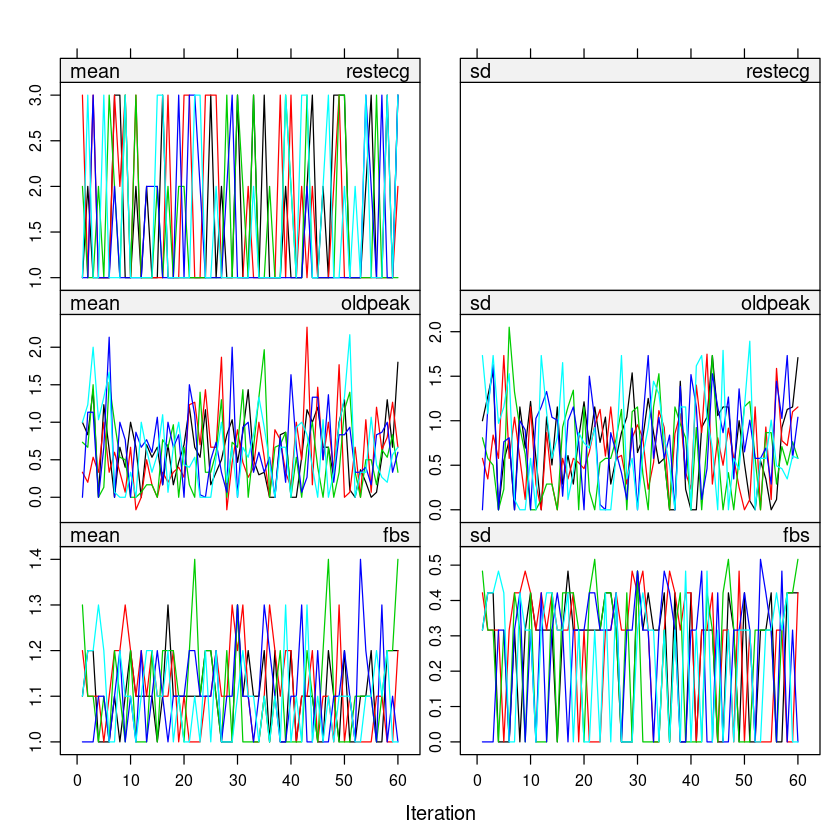

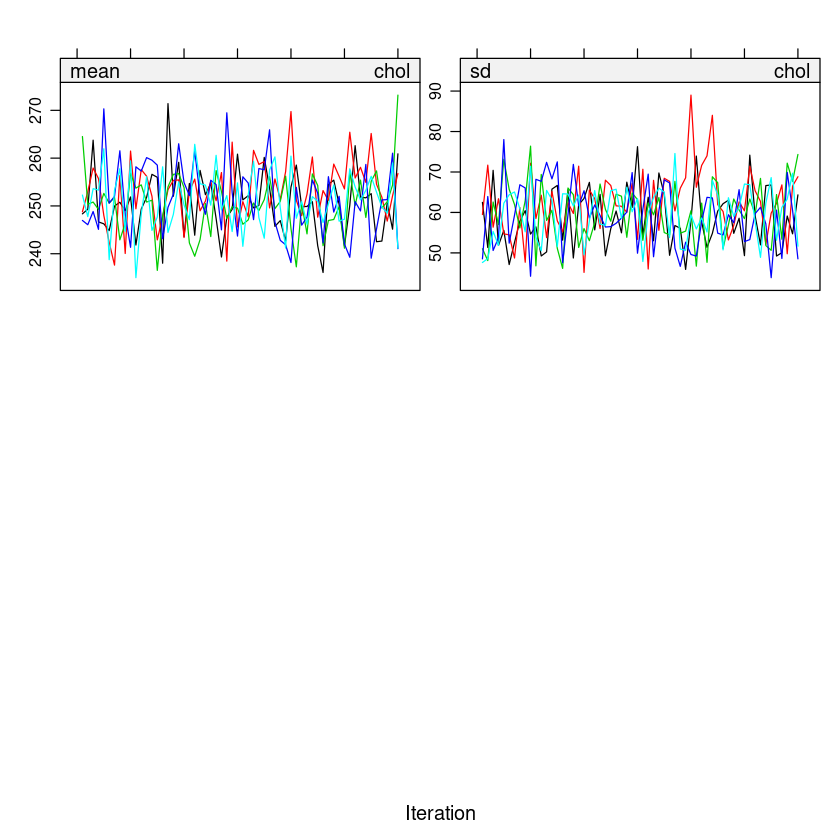

In [16]:
plot(imp, c("restecg", "oldpeak", "fbs", "chol"))

In [17]:
imputed_fbs <- as.numeric(imputed_dataset[is.na(uci_dataset$df$fbs),]$fbs)
summary(imputed_fbs)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     1.0     1.0     1.2     1.0     2.0 

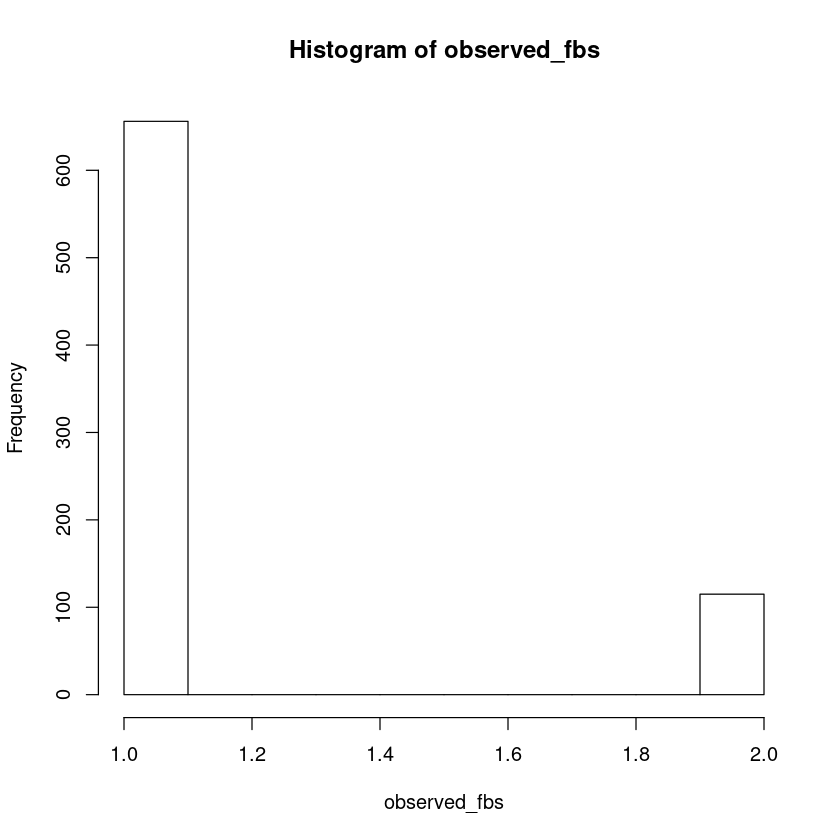

In [18]:
observed_fbs <- as.numeric(uci_dataset$df[!is.na(uci_dataset$df$fbs),]$fbs)
hist(observed_fbs)

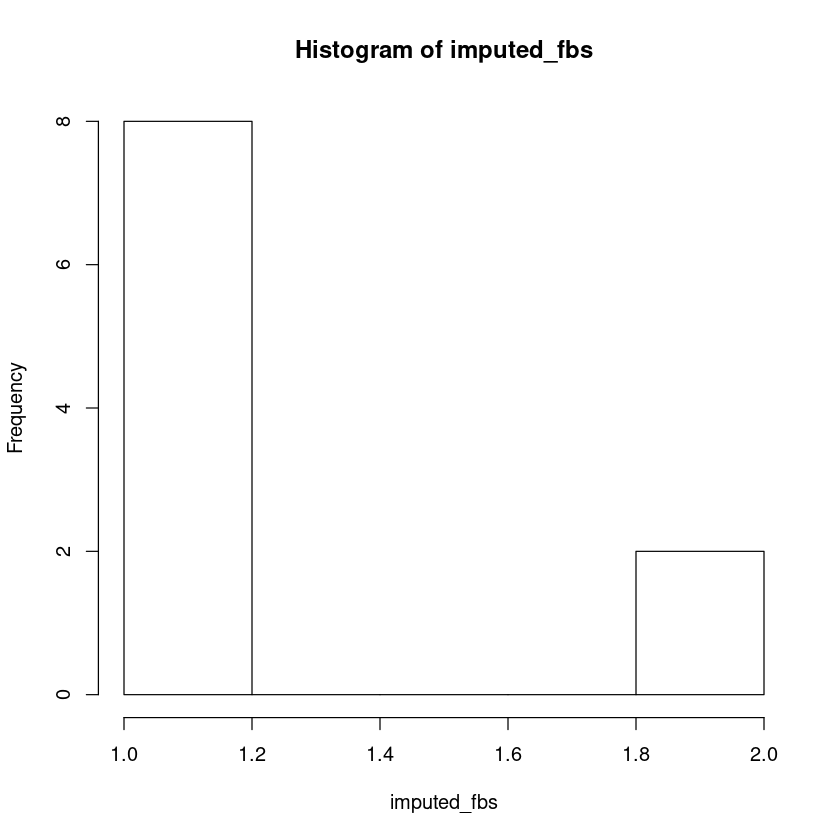

In [19]:
hist(imputed_fbs)

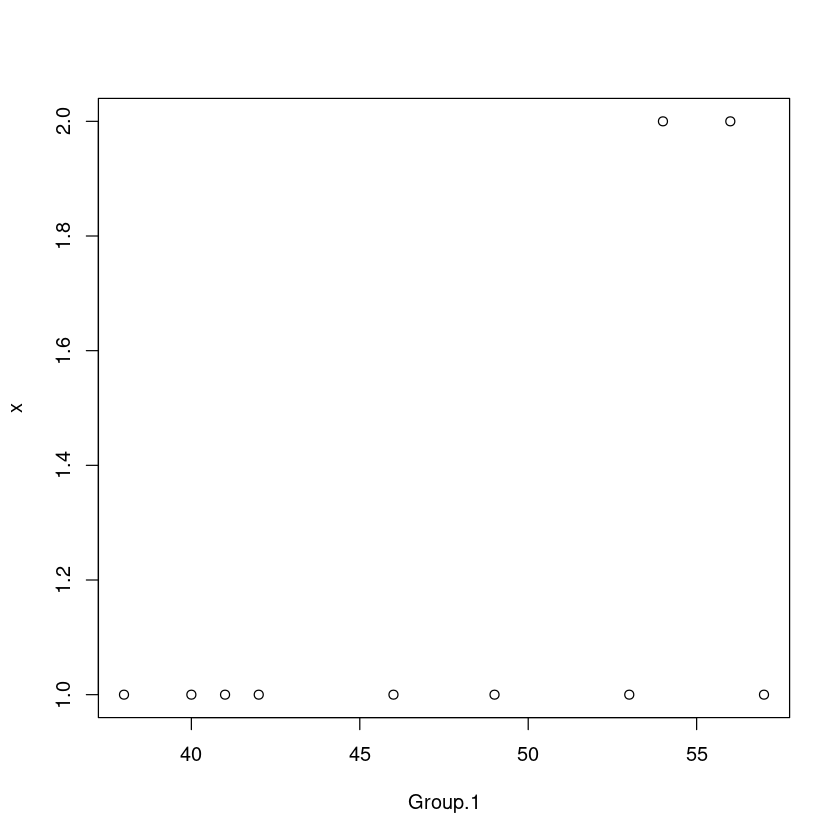

In [20]:
age_missing_fbs <- uci_dataset$df[is.na(uci_dataset$df$fbs),]$age
mean_imputed_fbs <- aggregate(imputed_fbs, list(age_missing_fbs), mean)
plot(mean_imputed_fbs)

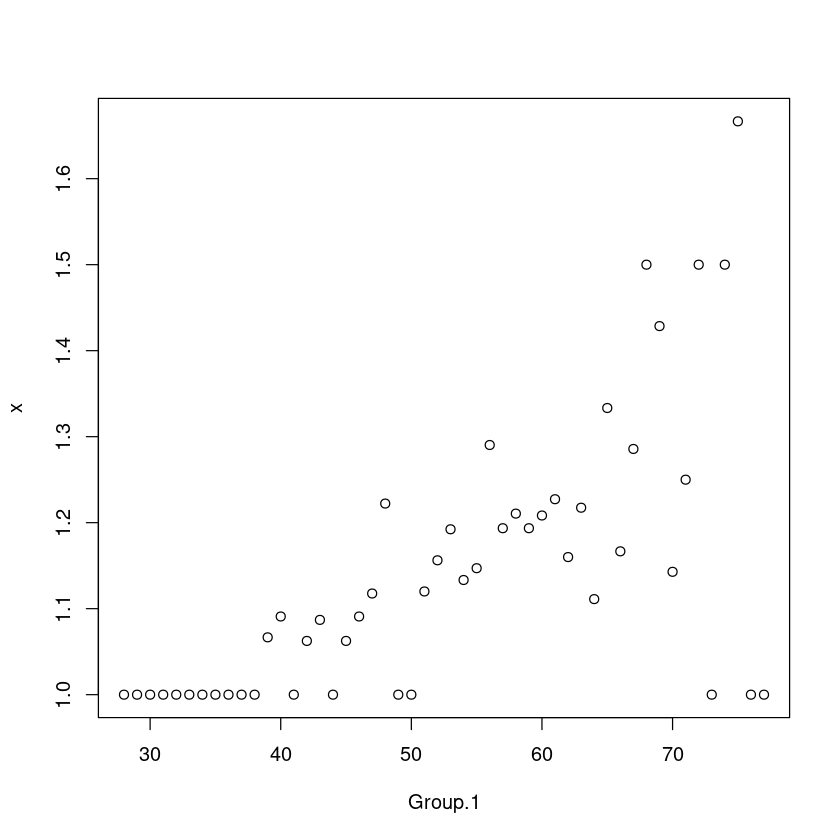

In [21]:
age_with_fbs <- uci_dataset$df[!is.na(uci_dataset$df$fbs),]$age
mean_observed_fbs <- aggregate(observed_fbs, list(age_with_fbs), mean)
plot(mean_observed_fbs)

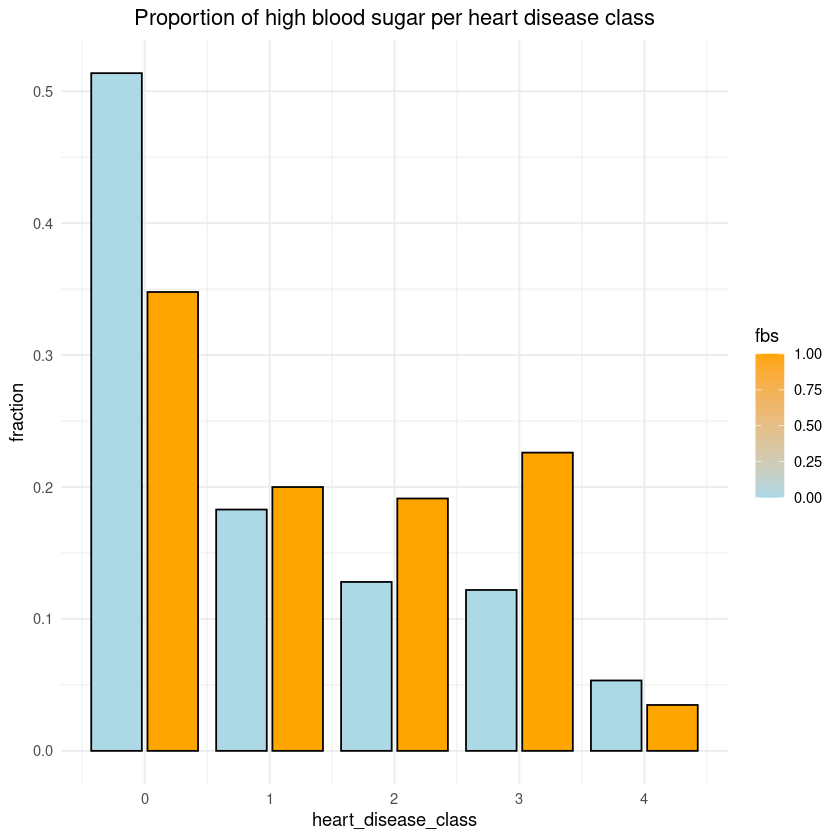

In [22]:
# Bar graph of heart disease categories grouped by observed fasting blood sugar.
categories_by_fbs <- group_by_attribute(uci_dataset$df, 'fbs', c(0, 1))
ggplot(categories_by_fbs, aes(fill=fbs, y=fraction, x=heart_disease_class)) + ggtitle(label='Proportion of high blood sugar per heart disease class') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='orange') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

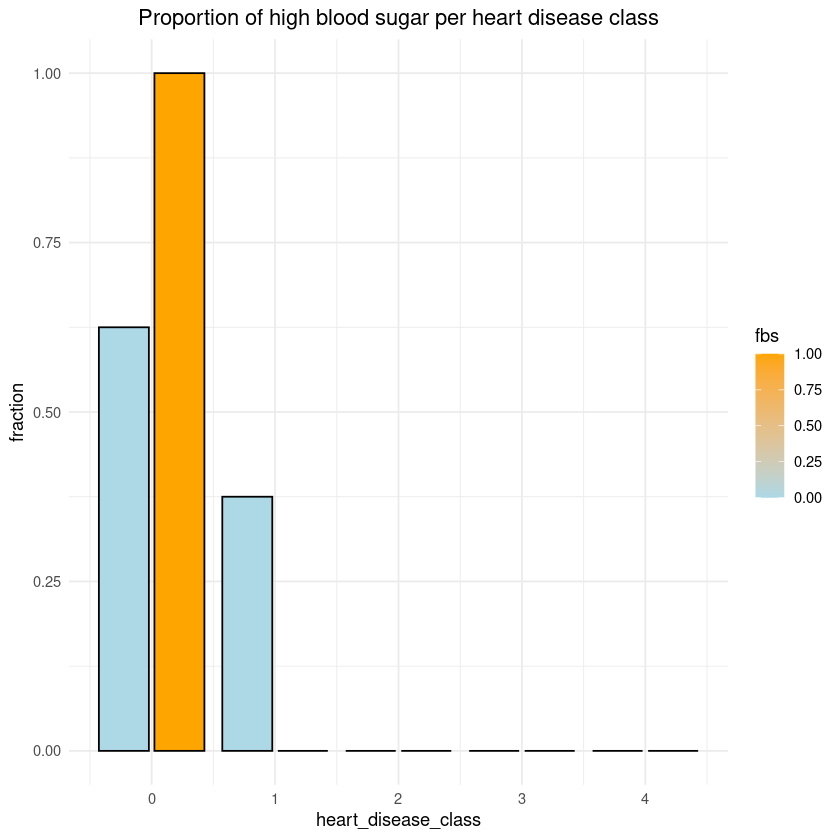

In [23]:
# Bar graph of heart disease categories grouped by imputed fasting blood sugar.
imputed_fbs_dataset <- imputed_dataset[is.na(uci_dataset$df$fbs),]
categories_by_imputed_fbs <- group_by_attribute(imputed_fbs_dataset, 'fbs', c(0, 1))
ggplot(categories_by_imputed_fbs, aes(fill=fbs, y=fraction, x=heart_disease_class)) + ggtitle(label='Proportion of high blood sugar per heart disease class') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='orange') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [24]:
imputed_restecg <- imputed_dataset[is.na(uci_dataset$df$restecg),]
imputed_restecg

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,chol,target
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
542,55,1,1,140,0,2,136,0,0,295,3


In [25]:
imputed_oldpeak <- imputed_dataset[is.na(uci_dataset$df$oldpeak),]
imputed_oldpeak

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,chol,target
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
646,55,1,2,110,1,1,180,0,0.0,214,0
667,62,1,1,112,0,1,150,1,3.4,258,1
693,53,1,3,155,1,1,160,0,2.0,175,0


In [26]:
observed_chol <- imputed_dataset[!is.na(uci_dataset$df$chol),]
summary(observed_chol)

      age             sex               cp           trestbps     fbs    
 Min.   :28.00   Min.   :0.0000   Min.   :1.000   Min.   : 92.0   0:573  
 1st Qu.:46.00   1st Qu.:0.0000   1st Qu.:2.000   1st Qu.:120.0   1:103  
 Median :54.00   Median :1.0000   Median :4.000   Median :130.0          
 Mean   :52.57   Mean   :0.7411   Mean   :3.167   Mean   :132.7          
 3rd Qu.:59.00   3rd Qu.:1.0000   3rd Qu.:4.000   3rd Qu.:140.0          
 Max.   :77.00   Max.   :1.0000   Max.   :4.000   Max.   :200.0          
                                                  NA's   :1              
 restecg    thalach          exang           oldpeak            chol    
 0:407   Min.   : 69.0   Min.   :0.0000   Min.   :0.0000   Min.   : 85  
 1: 99   1st Qu.:123.8   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:210  
 2:170   Median :142.0   Median :0.0000   Median :0.5000   Median :240  
         Mean   :141.2   Mean   :0.3757   Mean   :0.9081   Mean   :247  
         3rd Qu.:160.0   3rd Qu.:1.0000   3

In [27]:
imputed_chol <- imputed_dataset[is.na(uci_dataset$df$chol),]
summary(imputed_chol)

      age            sex               cp           trestbps   fbs    restecg
 Min.   :29.0   Min.   :0.0000   Min.   :1.000   Min.   :100   0:91   0:67   
 1st Qu.:49.0   1st Qu.:1.0000   1st Qu.:3.000   1st Qu.:120   1:14   1:30   
 Median :56.0   Median :1.0000   Median :4.000   Median :130          2: 8   
 Mean   :55.5   Mean   :0.9048   Mean   :3.495   Mean   :134                 
 3rd Qu.:61.0   3rd Qu.:1.0000   3rd Qu.:4.000   3rd Qu.:140                 
 Max.   :76.0   Max.   :1.0000   Max.   :4.000   Max.   :200                 
    thalach        exang           oldpeak             chol      
 Min.   : 60   Min.   :0.0000   Min.   :-1.0000   Min.   :166.0  
 1st Qu.:106   1st Qu.:0.0000   1st Qu.: 0.0000   1st Qu.:219.0  
 Median :120   Median :1.0000   Median : 0.0000   Median :254.0  
 Mean   :123   Mean   :0.5048   Mean   : 0.7124   Mean   :260.9  
 3rd Qu.:140   3rd Qu.:1.0000   3rd Qu.: 1.5000   3rd Qu.:286.0  
 Max.   :188   Max.   :1.0000   Max.   : 3.5000   Max.   :

In [28]:
sum(is.na(imputed_chol))

[1] 0

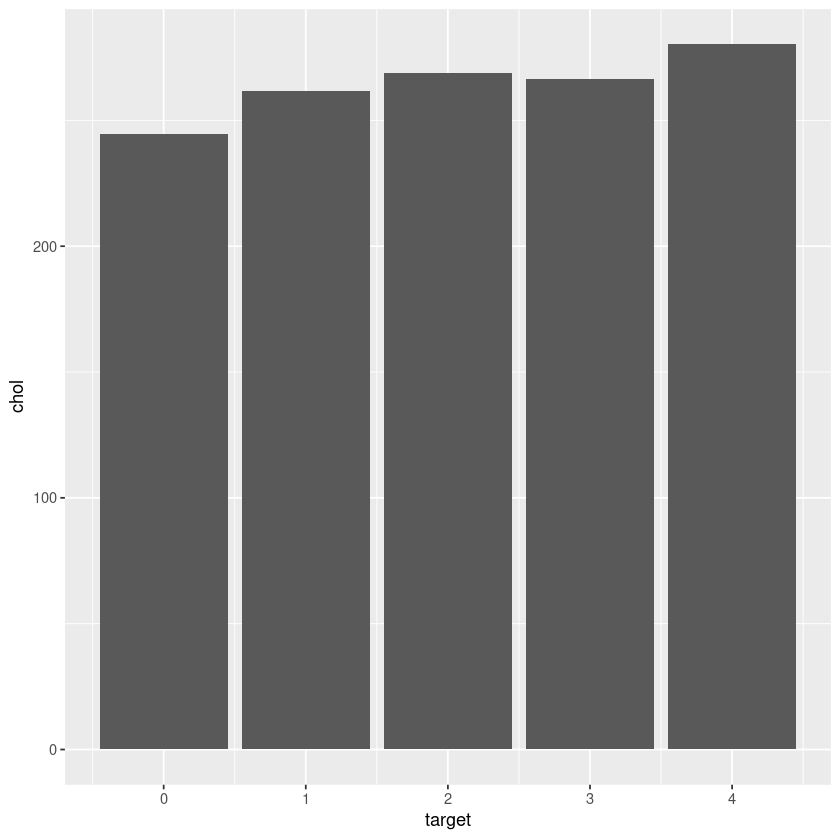

In [29]:
# Bar graph of heart disease categories grouped by imputed cholesterol.
imputed_chol_dataset <- imputed_dataset[is.na(uci_dataset$df$chol),]
aggregate_data <- aggregate(chol ~ target, imputed_chol_dataset, mean, na.rm = TRUE)
ggplot(data=aggregate_data, aes(x=target, y=chol)) + geom_bar(stat = "identity")

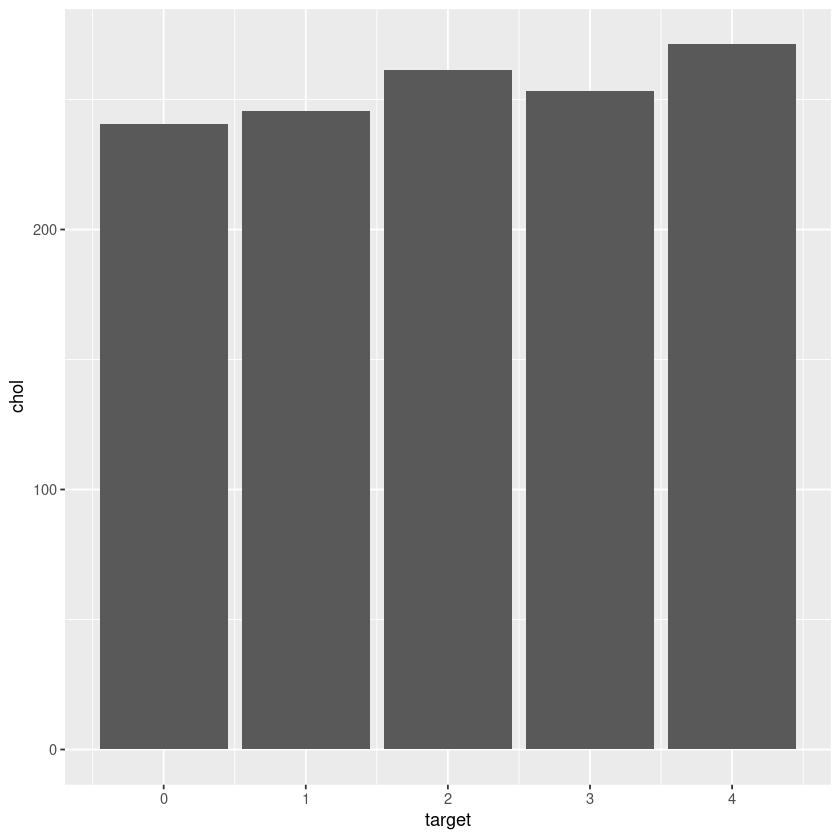

In [30]:
# Bar graph of heart disease categories grouped by observed cholesterol.
observed_chol_dataset <- imputed_dataset[!is.na(uci_dataset$df$chol),]
aggregate_data <- aggregate(chol ~ target, observed_chol_dataset, mean, na.rm = TRUE)
ggplot(data=aggregate_data, aes(x=target, y=chol)) + geom_bar(stat = "identity")